In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from arlbench.core.algorithms import DQN, PPO, SAC
import os

sns.set_context("talk")

In [55]:
replacement_dict = {"atari_qbert": "Atari", 'atari_double_dunk': "Atari", 'atari_phoenix': "Atari", 'atari_this_game': "Atari", 'atari_battle_zone': "Atari", 
                    'box2d_lunar_lander': "Box2d", "box2d_bipedal_walker": "Box2d", 'cc_acrobot': "CC", 'cc_cartpole': "CC", 'cc_mountain_car': "CC", "cc_pendulum": "CC", 'cc_continuous_mountain_car': "CC",
                    'minigrid_door_key': "XLand", 'minigrid_empty_random': "XLand", 'minigrid_four_rooms': "XLand", 
                    'minigrid_unlock': "XLand", "brax_ant": "Brax", "brax_halfcheetah": "Brax", "brax_hopper": "Brax", "brax_humanoid": "Brax"}
algorithms = {"dqn": DQN, "ppo": PPO, "sac": SAC}
envs = ["atari_qbert", 'atari_double_dunk', 'atari_phoenix', 'atari_this_game', 'atari_battle_zone', 
        'box2d_lunar_lander', 'box2d_bipedal_walker', 'cc_acrobot', 'cc_cartpole', 'cc_mountain_car', 'cc_pendulum', 'cc_continuous_mountain_car',
        'minigrid_door_key', 'minigrid_empty_random', 'minigrid_four_rooms', 'minigrid_unlock', 'brax_ant', 'brax_halfcheetah', 'brax_hopper', 'brax_humanoid']
subsets = {"dqn": ["cc_acrobot", "atari_battle_zone", "atari_double_dunk", "minigrid_four_rooms", "minigrid_empty_random"], 
           "ppo": ['box2d_lunar_lander', "atari_battle_zone", "atari_phoenix", 'brax_humanoid', 'minigrid_empty_random'], 
           "sac": ['cc_continuous_mountain_car', 'box2d_bipedal_walker', 'brax_halfcheetah', "cc_pendulum"]}
plotkeys = {"atari_qbert": "QBert", 'atari_double_dunk': "Double Dunk", 'atari_phoenix': "Phoenix", 'atari_this_game': "This Game", 'atari_battle_zone': "Battle Zone", 
            'box2d_lunar_lander': "Lunar Lander", 'box2d_bipedal_walker': "Bipedal Walker", 'cc_acrobot': "Acrobot", 'cc_cartpole': "Cartpole", 'cc_mountain_car': "Mt. Car", "cc_pendulum": "Pendulum", 'cc_continuous_mountain_car': "Cont. Mt. Car",
            'minigrid_door_key': "Door Key", 'minigrid_empty_random': "Empty Random", 'minigrid_four_rooms': "Four Rooms", 
            'minigrid_unlock': "Unlock", "brax_ant": "Ant", "brax_halfcheetah": "Halfcheetah", "brax_hopper": "Hopper", "brax_humanoid": "Humanoid"}


In [56]:
def remove_outliers(data):
    Q1 = data["performance"].quantile(0.25)
    Q3 = data["performance"].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    print(Q1)
    filtered_data = data[(data["performance"] >= lower_bound)]  # we only want to remove very bad performances
    return filtered_data

In [57]:
def normalize_env_scores(data):
    data["performance"] = (data["performance"] - min(data.dropna()["performance"])) / (max(data.dropna()["performance"]) - min(data.dropna()["performance"]))
    data["performance"] = data["performance"].clip(0,1)
    return data

In [58]:
def normalize_env_scores_custom(data, env_name):
    min_p = min(data.dropna()["performance"])
    max_p = max(data.dropna()["performance"])

    if "brax" in env_name:
        min_p = -2000
    elif "box2d" in env_name:
        min_p = -200

    print(min_p)
    
    data["performance"] = (data["performance"] - min_p) / (max_p - min_p)
    data["performance"] = data["performance"].clip(0,1)
    return data

In [59]:
def get_boxenplot(data, domain=False, domain_single=None, subset=False, algorithm=None):
    if domain:
        data["environment"] = data["environment"].replace(replacement_dict)
    if domain_single in ["Atari", "CC", "Box2d", "XLand", "Brax"]:
        subdomains = [k for k in replacement_dict.keys() if replacement_dict[k] == domain_single]
        data = data[data["environment"].isin(subdomains)]
    if subset:
        data = data[data["environment"].isin(subsets[algorithm])]

    fig = sns.boxenplot(data.replace(plotkeys), x="environment", y="performance")
    #plt.xticks(rotation=70)
    plt.tight_layout()
    plt.xlabel('Environment Domain' if domain else 'Environment')
    plt.ylabel('Normalized Return')
    return fig

def get_kdeplot(data, domain=False, domain_single=None, subset=False, algorithm=None):
    if domain:
        data["environment"] = data["environment"].replace(replacement_dict)
    if domain_single in ["Atari", "CC", "Box2d", "XLand", "Brax"]:
        subdomains = [k for k in replacement_dict.keys() if replacement_dict[k] == domain_single]
        data = data[data["environment"].isin(subdomains)]
    if subset:
        data = data[data["environment"].isin(subsets[algorithm])]


    fig = sns.kdeplot(data.replace(plotkeys), x="performance", hue="environment")
    plt.xlabel('Environment')
    plt.ylabel('Normalized Return')
    return fig

def get_pairplot(data, domain=False, domain_single=None, subset=False, algorithm=None):
    if domain:
        data["environment"] = data["environment"].replace(replacement_dict)
    if domain_single in ["Atari", "CC", "Box2d", "XLand", "Brax"]:
        subdomains = [k for k in replacement_dict.keys() if replacement_dict[k] == domain_single]
        data = data[data["environment"].isin(subdomains)]
    if subset:
        data = data[data["environment"].isin(subsets[algorithm])]

    fig = sns.pairplot(data.replace(plotkeys), hue="environment", kind="kde", x_vars=["performance", "run_id", "seed"], y_vars=["performance", "run_id", "seed"])
    return fig

In [60]:
def load_data(algorithm, env):
    source_file = f"../results_combined/sobol/{env}_{algorithm}.csv"
    return pd.read_csv(source_file)

In [71]:
algorithm = "sac"
performance_data = []
for env in envs:
    if os.path.exists(f"../results_combined/sobol/{env}_{algorithm}.csv"):
        env_data = load_data(algorithm, env)
        env_data["performance"] = -1 * env_data["performance"]  # high returns are best
        print(env)
        #filtered_env_data = remove_outliers(env_data)
        normalized_env_data = normalize_env_scores_custom(env_data, env)
        normalized_env_data["environment"] = env #plotkeys[env]
        performance_data.append(normalized_env_data)
performance_data = pd.concat(performance_data, ignore_index=True)

box2d_bipedal_walker
-200
cc_pendulum
-1726.534394113309
cc_continuous_mountain_car
-99.89999999999822
brax_ant
-2000
brax_halfcheetah
-2000
brax_hopper
-2000
brax_humanoid
-2000


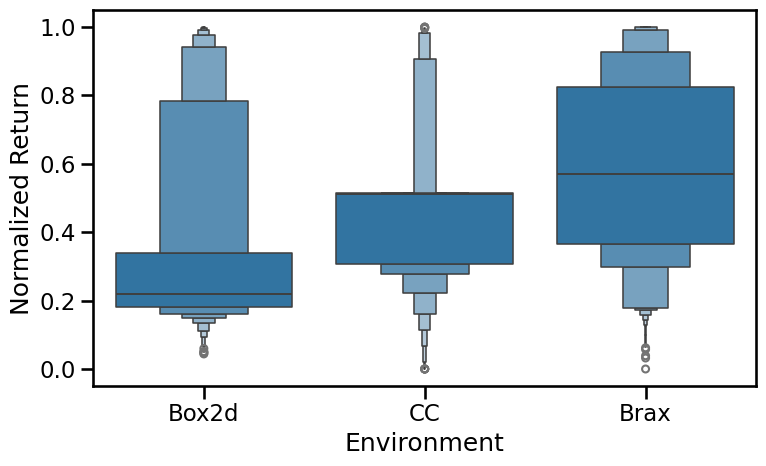

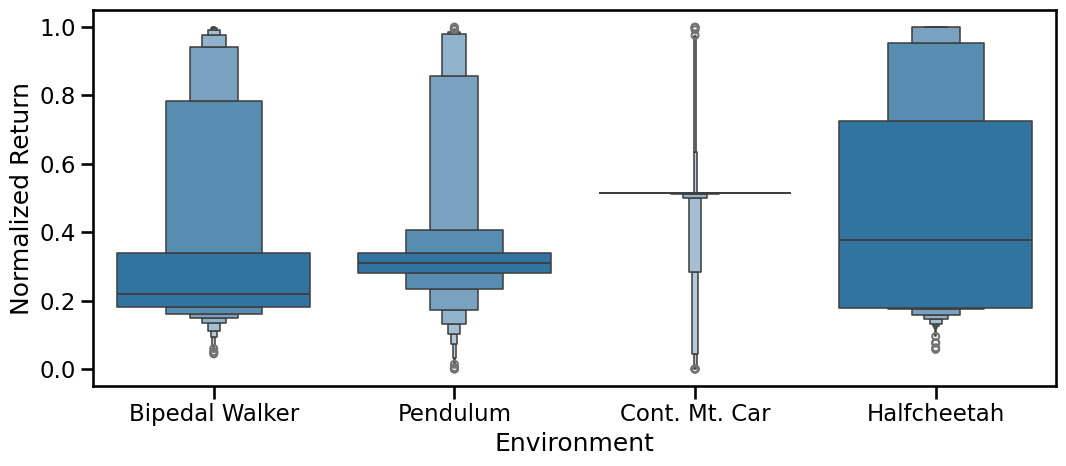

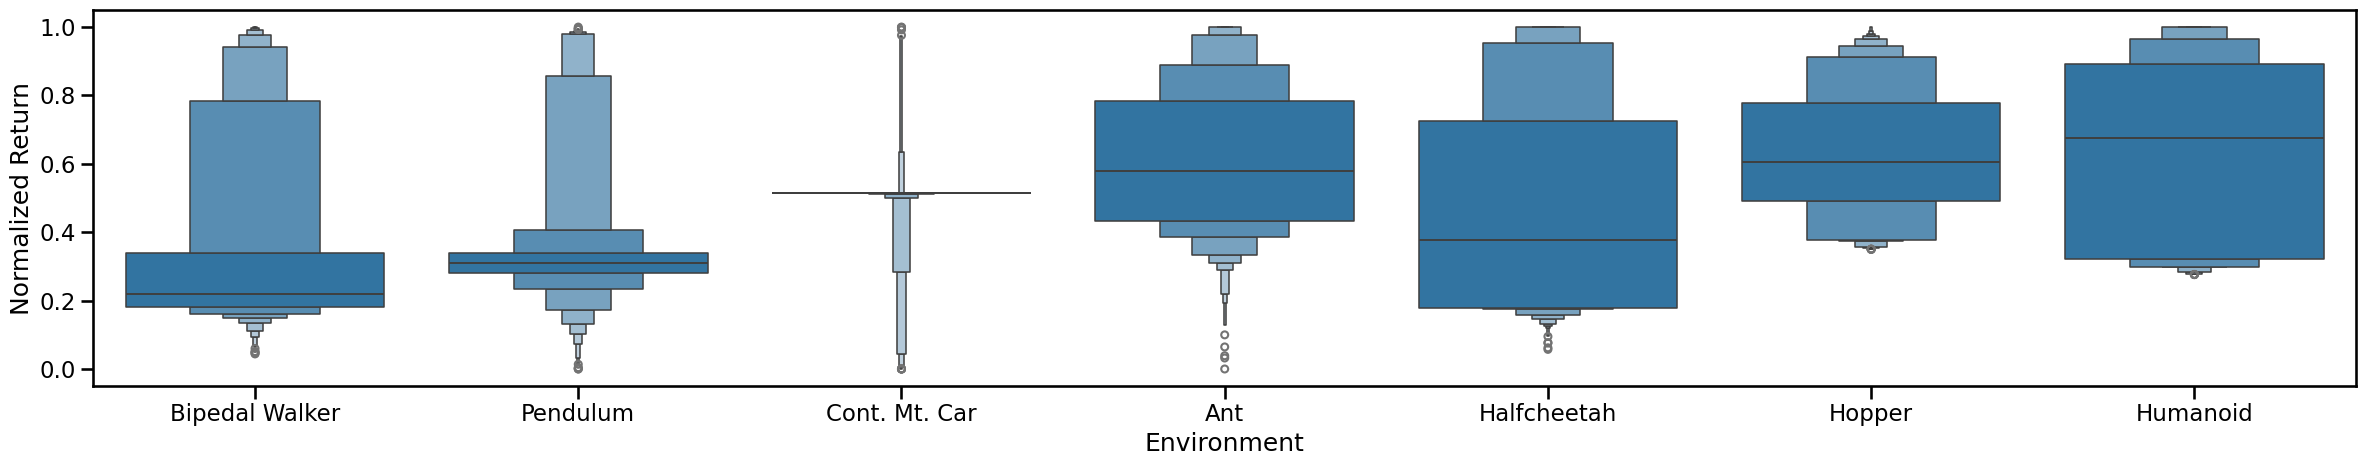

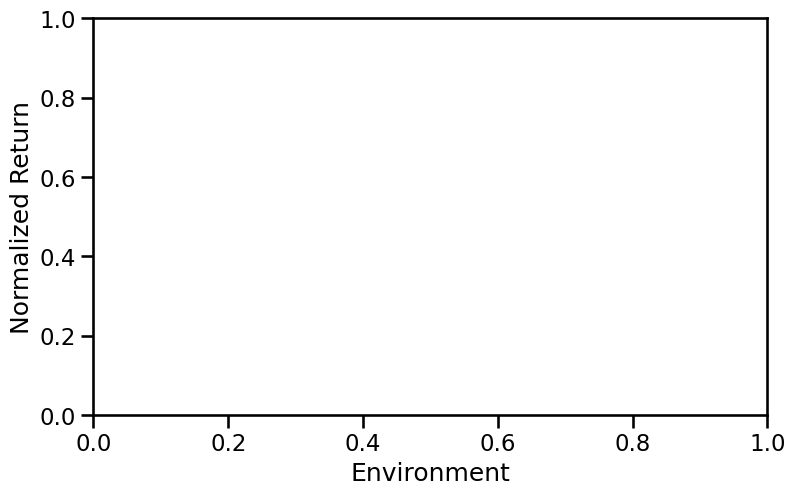

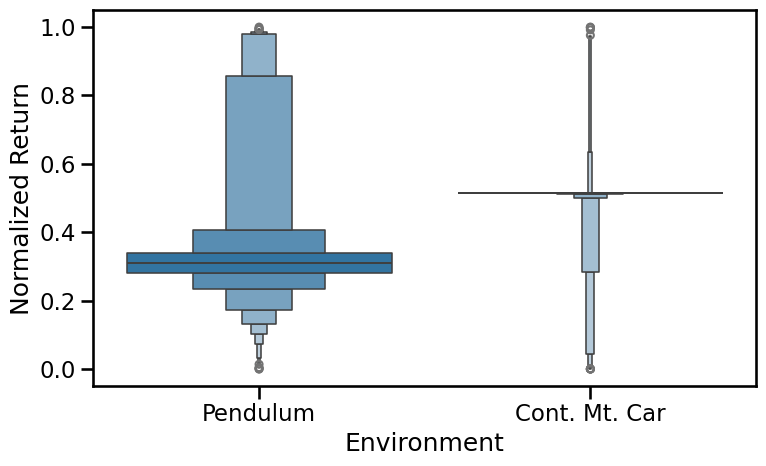

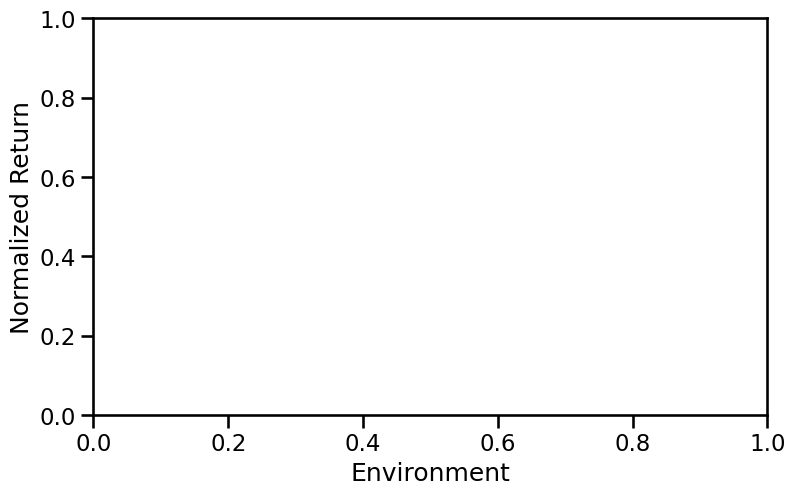

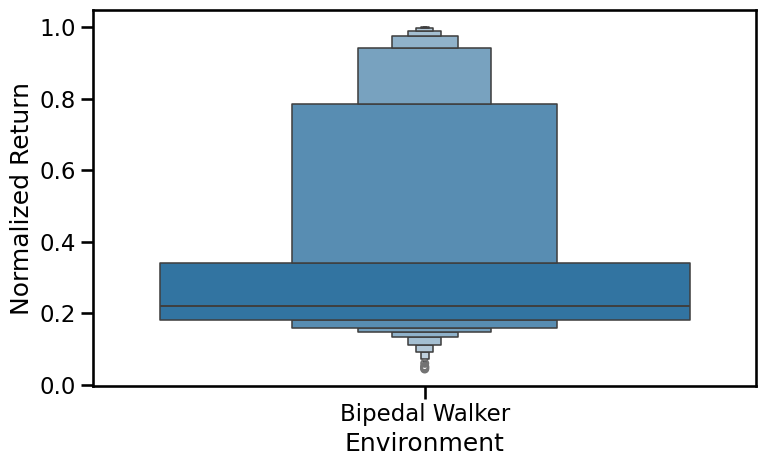

In [72]:
plt.figure(figsize=(8, 5))
get_boxenplot(performance_data.copy(), True)
plt.savefig(f"performance_plots/boxen/boxenplot_{algorithm}_domains.png")
plt.figure(figsize=(11, 5))
get_boxenplot(performance_data.copy(), subset=True, algorithm=algorithm)
plt.savefig(f"performance_plots/boxen/boxenplot_{algorithm}_subset.png")
plt.figure(figsize=(24, 5))
get_boxenplot(performance_data.copy())
plt.savefig(f"performance_plots/boxen/boxenplot_{algorithm}_all.png")
plt.figure(figsize=(8, 5))
get_boxenplot(performance_data.copy(), domain_single="Atari")
plt.savefig(f"performance_plots/boxen/boxenplot_{algorithm}_atari.png")
plt.figure(figsize=(8, 5))
get_boxenplot(performance_data.copy(), domain_single="CC")
plt.savefig(f"performance_plots/boxen/boxenplot_{algorithm}_cc.png")
plt.figure(figsize=(8, 5))
get_boxenplot(performance_data.copy(), domain_single="XLand")
plt.savefig(f"performance_plots/boxen/boxenplot_{algorithm}_minigrid.png")
plt.figure(figsize=(8, 5))
get_boxenplot(performance_data.copy(), domain_single="Box2d")
plt.savefig(f"performance_plots/boxen/boxenplot_{algorithm}_box2d.png")


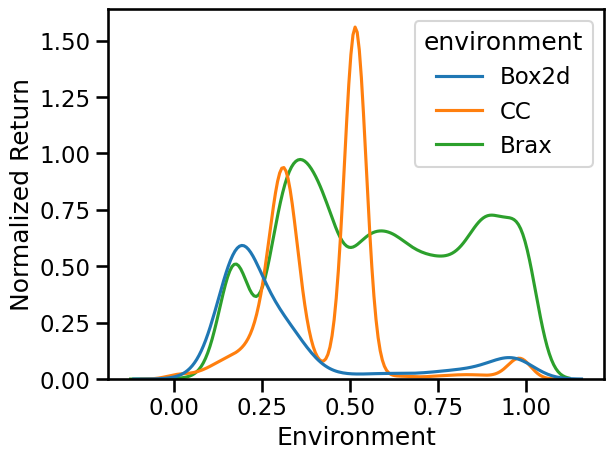

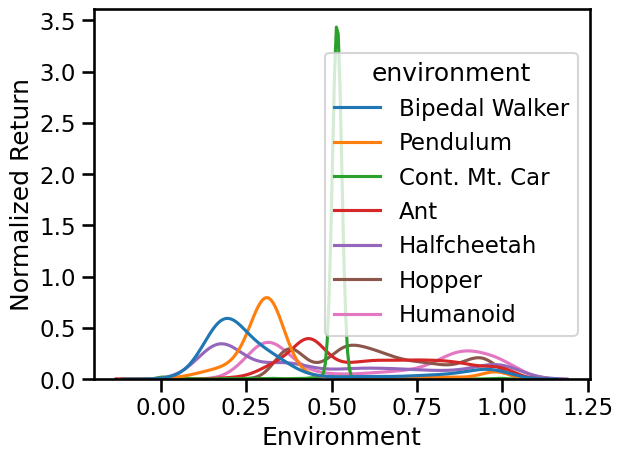

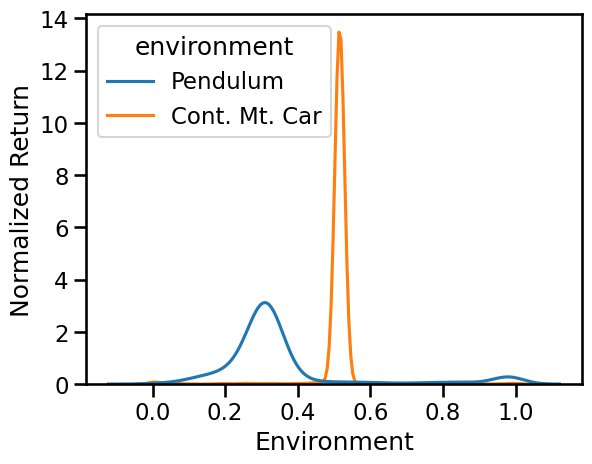

<Figure size 640x480 with 0 Axes>

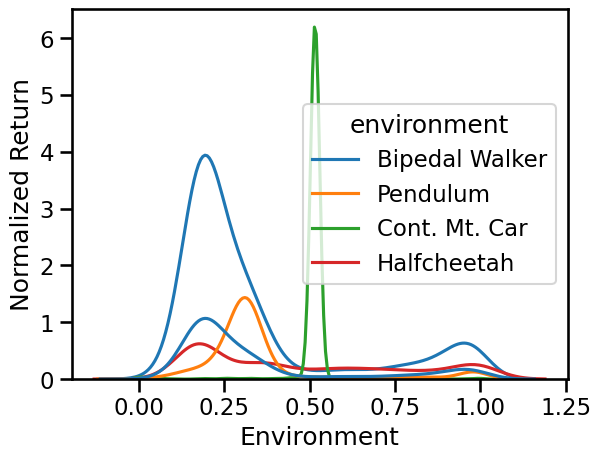

In [73]:
get_kdeplot(performance_data.copy(), True)
plt.savefig(f"performance_plots/kde/kdeplot_{algorithm}_domains.png")
plt.figure()
get_kdeplot(performance_data.copy())
plt.savefig(f"performance_plots/kde/kdeplot_{algorithm}_full.png")
plt.figure()
if algorithm != "sac":
    get_kdeplot(performance_data.copy(), domain_single="Atari")
    plt.savefig(f"performance_plots/kde/kdeplot_{algorithm}_atari.png")
    plt.figure()
get_kdeplot(performance_data.copy(), domain_single="CC")
plt.savefig(f"performance_plots/kde/kdeplot_{algorithm}_cc.png")
plt.figure()
if algorithm != "sac":
    get_kdeplot(performance_data.copy(), domain_single="XLand")
    plt.savefig(f"performance_plots/kde/kdeplot_{algorithm}_minigrid.png")
plt.figure()
get_kdeplot(performance_data.copy(), domain_single="Box2d")
plt.savefig(f"performance_plots/kde/kdeplot_{algorithm}_box2d.png")
get_kdeplot(performance_data.copy(), subset=True, algorithm=algorithm)
plt.savefig(f"performance_plots/kde/kdeplot_{algorithm}_subset.png")

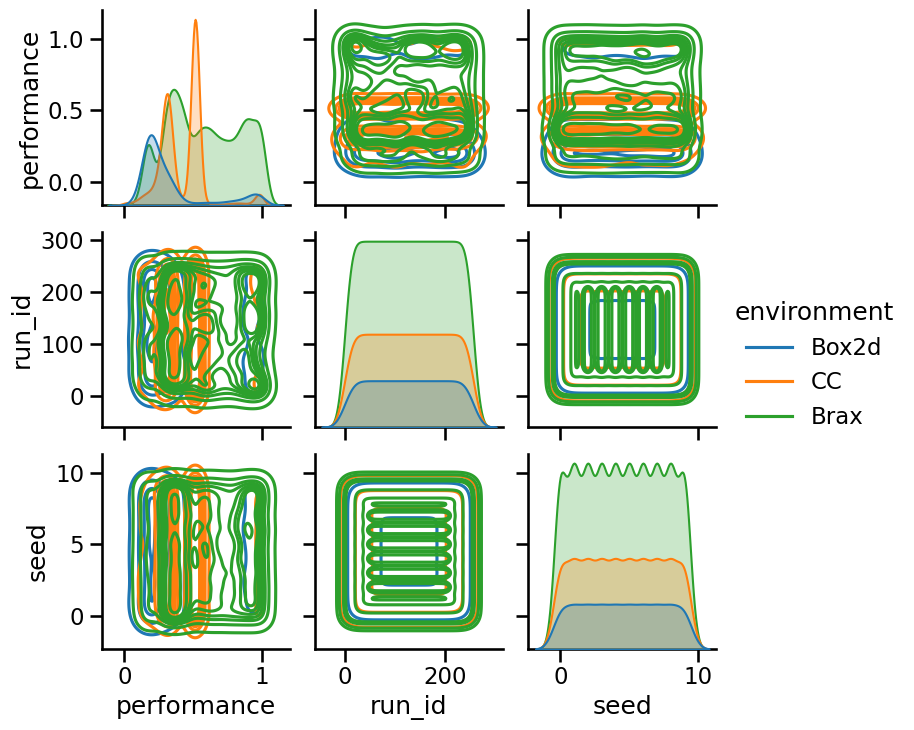

<Figure size 640x480 with 0 Axes>

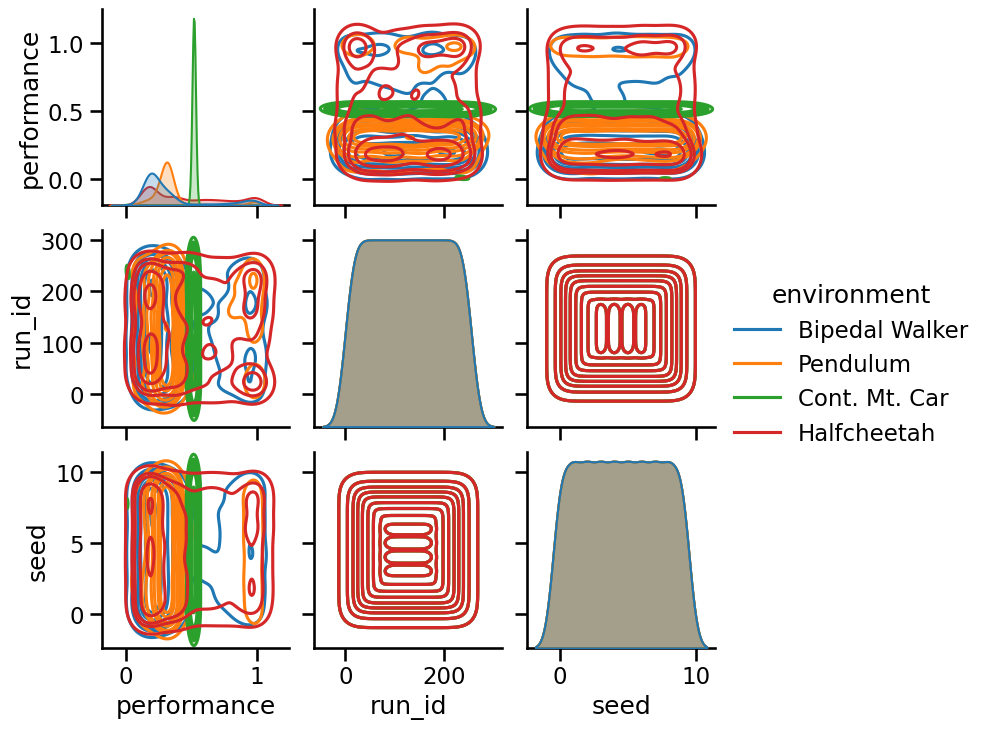

<Figure size 640x480 with 0 Axes>

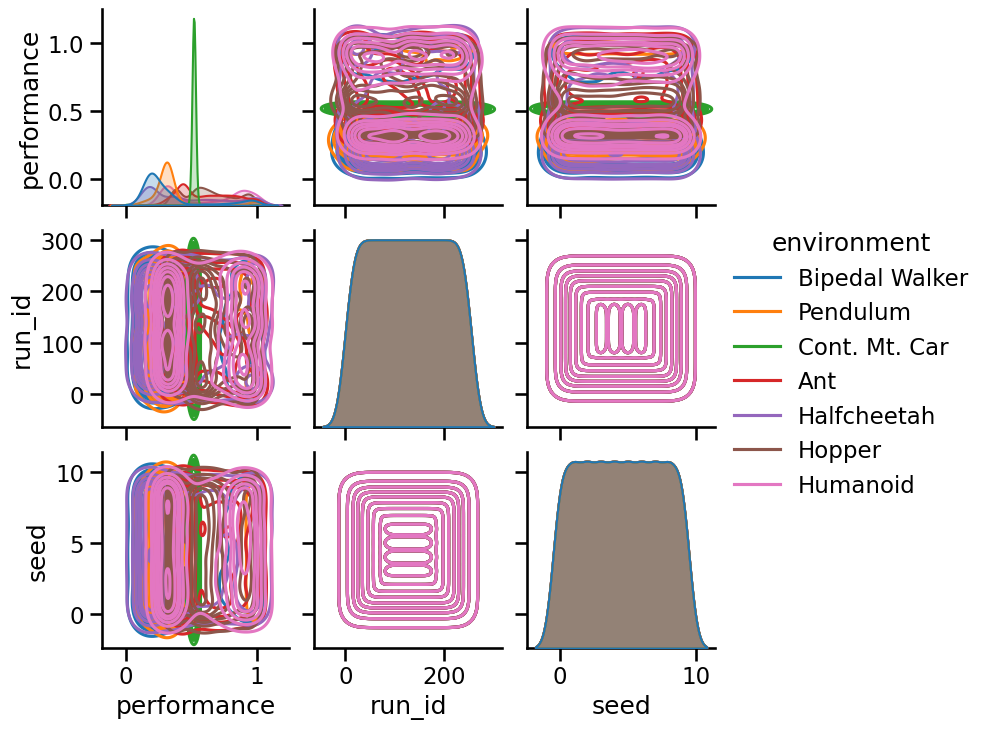

<Figure size 640x480 with 0 Axes>

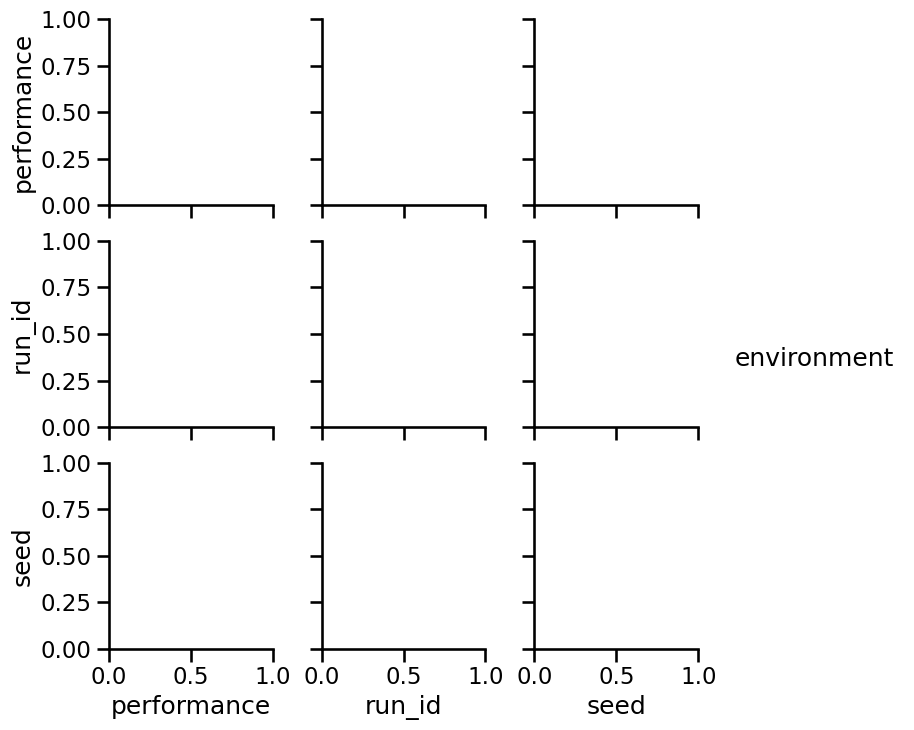

<Figure size 640x480 with 0 Axes>

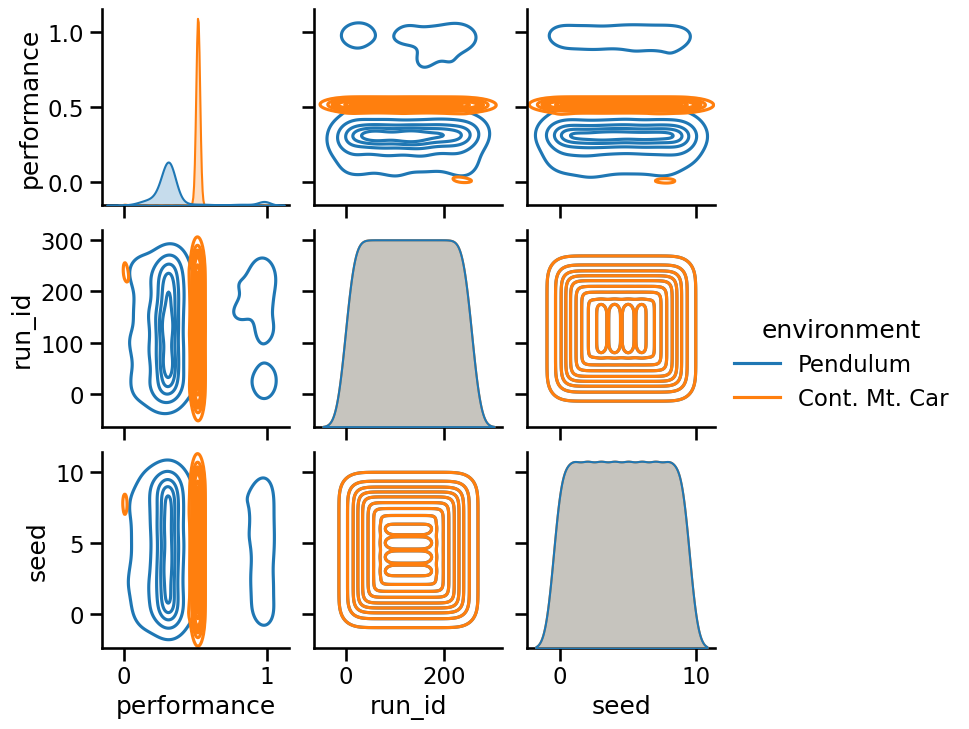

<Figure size 640x480 with 0 Axes>

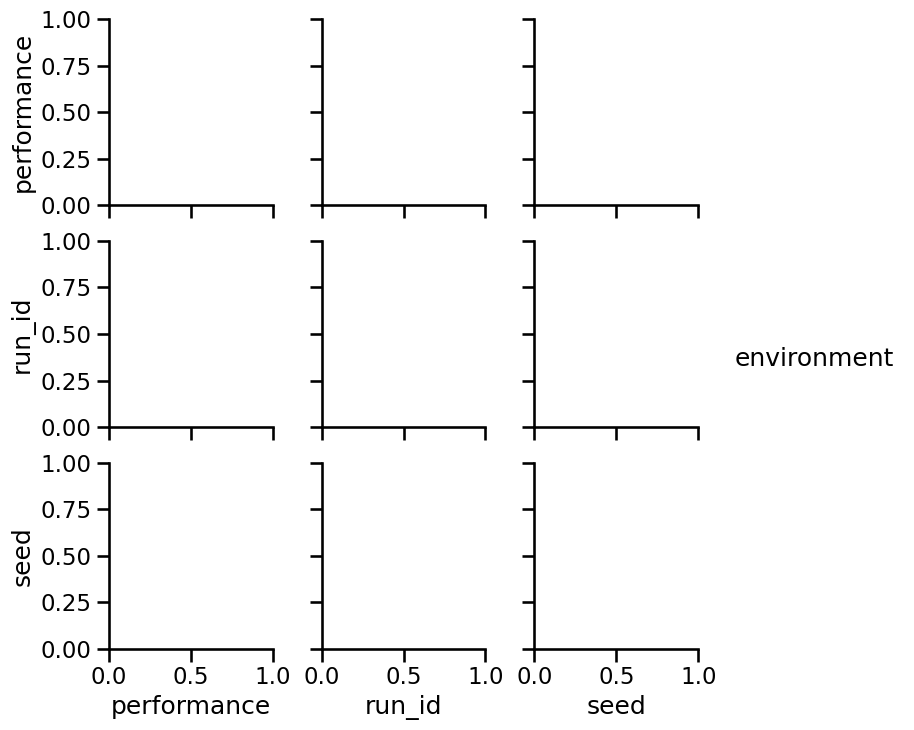

<Figure size 640x480 with 0 Axes>

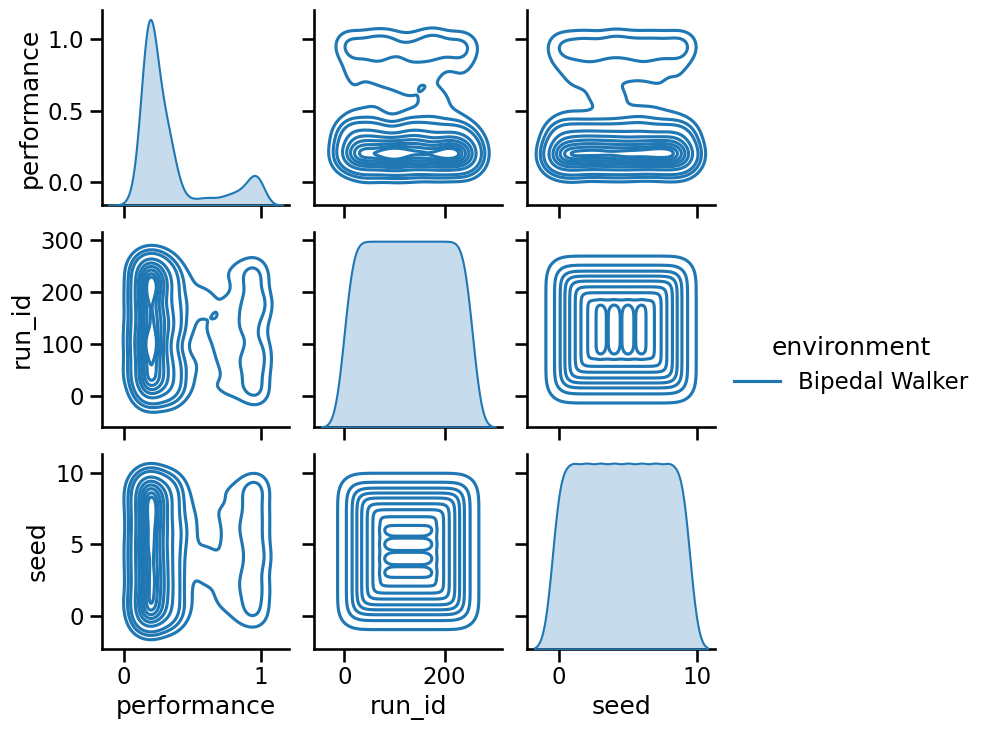

In [74]:
get_pairplot(performance_data.copy(), True)
plt.savefig(f"performance_plots/pair/pairplot_{algorithm}_domains.png")
plt.figure()
get_pairplot(performance_data.copy(), subset=True, algorithm=algorithm)
plt.savefig(f"performance_plots/pair/pairplot_{algorithm}_subset.png")
plt.figure()
get_pairplot(performance_data.copy())
plt.savefig(f"performance_plots/pair/pairplot_{algorithm}_all.png")
plt.figure()
get_pairplot(performance_data.copy(), domain_single="Atari")
plt.savefig(f"performance_plots/pair/pairplot_{algorithm}_atari.png")
plt.figure()
get_pairplot(performance_data.copy(), domain_single="CC")
plt.savefig(f"performance_plots/pair/pairplot_{algorithm}_cc.png")
plt.figure()
get_pairplot(performance_data.copy(), domain_single="XLand")
plt.savefig(f"performance_plots/pair/pairplot_{algorithm}_minigrid.png")
plt.figure()
get_pairplot(performance_data.copy(), domain_single="Box2d")
plt.savefig(f"performance_plots/pair/pairplot_{algorithm}_box2d.png")